# Prediction of Diabetes

Following project presents a prediction model which predicts if the person has diabetes or not using the following data from UCI Machine Learning Repository.

[Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) 

We will use Logistic Regression technique to acheive the above stated goal and then tune our model for better prediction.

In [51]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')

In [18]:
# read the data into a Pandas DataFrame
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'

#as the dataset has no head, col_names will be the header for the data
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age','label']

pima = pd.read_csv(url, header=None, names=col_names)

In [52]:
# print the first 5 rows of data from the dataframe
pima.head()
pandas_profiling.ProfileReport(pima)

Number of variables,9
Number of observations,768
Total Missing (%),0.0%
Total size in memory,54.1 KiB
Average record size in memory,72.1 B
Numeric,8
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [20]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']

# X is the input matrix
X = pima[feature_cols]

# y is the output vector
y = pima.label







# Split the data




In [21]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Logistic Regression

In [22]:

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)


# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()


0.723958333333


0    125
1     67
Name: label, dtype: int64

# Accuracy

Accuracy of our model is approx. 0.64. Let's see how we can improve the performance of our model. One way to improve the performance of our model is by changing the threshold of predicted probabilities for class membership. 

In [23]:
# calculate null accuracy using mean as we have binary classification coded as 0/1
max(y_test.mean(), 1 - y_test.mean())



0.6510416666666667

# Area Under Curve (AUC)

AUC(Area under the Curve) is used as single number summary of classifier performance. Higher value of AUC means better classifier. Applying 10-fold cross valdation with scoring parameter roc_auc will produce better result for the same Logistic Regression model.

In [27]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
print('The accuracy of the Logistic Regression is',cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean())

The accuracy of the Logistic Regression is 0.737823361823


As we have seen for the same logistic regression model, we have got better results at a higher computational cost on using 10-fold cross validation.

# Decision Tree

In [26]:
model=DecisionTreeClassifier()
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,y_test))

The accuracy of the Decision Tree is 0.645833333333


# SVM

In [28]:
types=['rbf','linear']
for i in types:
    model=svm.SVC(kernel=i)
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    print('Accuracy for SVM kernel=',i,'is',metrics.accuracy_score(prediction,y_test))

Accuracy for SVM kernel= rbf is 0.65625
Accuracy for SVM kernel= linear is 0.697916666667


# K nearest Neighbours

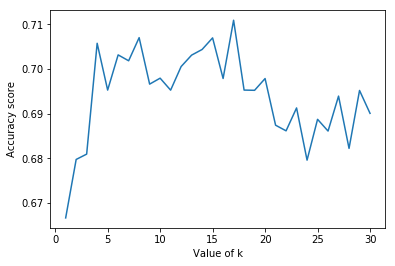

Best Accuracy for k nearest neighbours algorithm 17 is 0.7109022556390977


In [45]:
import operator
k_range=range(1,31)
a={}
scores=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn,X, y, cv=10, scoring='accuracy')
    a[k]=score.mean()
    scores.append(score.mean())
plt.plot(k_range, scores)
plt.xlabel("Value of k")
plt.ylabel("Accuracy score")
plt.show()

print('Best Accuracy for k nearest neighbours algorithm {} is {}' .format(max(a.items(), key=operator.itemgetter(1))[0], max(scores)))

In [61]:
accuracy=[]
classifiers=['Logistic Regression',  'Linear Svm','Radial Svm','Decision Tree','KNN']
models=[LogisticRegression(),svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),DecisionTreeClassifier(),KNeighborsClassifier(n_neighbors=17)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = 10,scoring = "accuracy")
    accuracy.append(cv_result.mean())
accuracy_df=pd.DataFrame(accuracy,index=classifiers)   
accuracy_df.columns=['Model Performace']    
accuracy_df

,Model Performace
Logistic Regression,0.688773
Linear Svm,0.691388
Radial Svm,0.666729
Decision Tree,0.679699
KNN,0.710902


As we did not get a very good prediction accuracy by any of the above models, let's utilize the technique of Ensembling. 

# Ensembling

Ensembling is a technique in which basic machine learning models are combined and utilized together to make a better prediction. One of the ensembling methods is Weighted Voting Ensemble in which each individual classifier is weighted according to it's prediction accuracy.

We will use the Top 3 classifiers i.e Linaer SVM, Radial(rbf) SVM and Logistic Regression classifiers.

In [57]:
#import Voting Classifier
from sklearn.ensemble import VotingClassifier 

In [63]:
linear_svc=svm.SVC(kernel='linear',C=0.1,gamma=10,probability=True)
radial_svm=svm.SVC(kernel='rbf',C=0.1,gamma=10,probability=True)
logreg=LogisticRegression(C=0.1)
knn=KNeighborsClassifier(n_neighbors=17)
decisiontree=DecisionTreeClassifier()


In [64]:
ensembled_model=VotingClassifier(estimators=[('Decision Tree',decisiontree), ('knn', knn),('Radial_svm', radial_svm), ('Logistic Regression', logreg),('Linear_svm',linear_svc)], 
                       voting='soft', weights=[2,5,1,2,3]).fit(X_train,y_train)
print('The ensembled model with all the classifiers is:',ensemble_model.score(X_test,y_test))

The ensembled model with all the classifiers is: 0.703125
